In [3]:
%load_ext autoreload
%autoreload 2
%matplotlib nbagg

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [4]:
from michigan.fusion import Fusion
from michigan.dataprep import Data
import matplotlib.pyplot as plt
from nansat import Nansat, Domain
from michigan.michigan import MichiganProcessing
from michigan.plotbox import show_it
import numpy as np
import pandas as pd
from sklearn.cluster import KMeans

In [5]:
def get_bottom(bathymetry_path=Fusion.BATHYMETRY_PATH):
    bathymetry = Nansat(bathymetry_path)
    bathymetry.reproject(Data.sbd_dom)
    # preparing of bottom field
    h = bathymetry[1]
    # all points there h >= 0 will marked as np.nan
    h = np.where(h >= 0, np.nan, np.float32(h) * -1)
    return h

def get_land_mask(bathymetry_path=Fusion.BATHYMETRY_PATH):
    h = self.get_bottom(bathymetry_path=bathymetry_path)
    # the mask of land
    land_mask = np.where(np.isfinite(h), np.nan, np.array(1))
    return land_mask

def get_h_mask(h_max, h_min=None, bathymetry_path=Fusion.BATHYMETRY_PATH, mask_val=np.nan):
    h_mask = get_bottom(bathymetry_path=bathymetry_path)
    h_mask[h_mask > h_max] = mask_val

    if h_min is not None:
        h_mask[h_mask < h_min] = mask_val

    return h_mask


In [22]:
import matplotlib.pyplot as plt
%matplotlib nbagg

def show_it(obj, name='no name', color='jet', limits=(0, None), 
            z10='off', size=(9, 6), coord_grid='off', land_mask=None,
           f_name=None, save_path=None):

    plt.figure(figsize=size)
    obj = np.array(obj)
    #obj[obj > limits[1]] = np.nan
    #obj[obj < limits[0]] = np.nan
    
    plt.imshow(obj, clim=limits, cmap=color)
    #clb = plt.colorbar(orientation='horizontal', fraction=0.07, pad=0.1)
    # clb.ax.set_title('This is a title', fontsize=18)
    #clb.ax.tick_params(labelsize=18) 
    # plt.title(name, y=1.08, fontsize=16)
    plt.tick_params(labelsize=14)
    #plt.text(950, 1150, 'TSM / %s / ' % get_date(os.path.split(f_name)[-1]) + 
    #         r'$\mathrm{g/m^3}$', fontsize=20, 
    #         bbox={'facecolor':'white', 'pad':5})
    
    # plt.text(1100, 1150, 'Bottom depth, meters', bbox={'facecolor':'white', 'pad':5}, fontsize=20)
    if land_mask is not None:
        plt.imshow(land_mask, cmap='Set1_r',)

    if coord_grid == 'on':
        y = np.arange(0.0, 1248.0, 1248.0 / 7)
        y_labels = [str(n) + ' N' for n in np.arange(45.3, 44.5, -0.1)]
        x = np.arange(0.0, 1952.0, 1952.0 / 6)
        x_labels = [str(w) + ' W' for w in np.arange(86.3, 85.2, -0.2)]
        plt.yticks(y, y_labels)
        plt.xticks(x, x_labels)
        # plt.xlabel('west')
        # plt.ylabel('north')
        plt.tick_params(axis='both', which='major', labelsize=18)
        plt.tick_params(axis='both', which='minor', labelsize=8)

    # black field is area which depth less than 10 meters
    # if z10 == 'on': plt.imshow(h_10m, cmap='gray')
    # plt.imshow(h_mask, cmap='Dark2')
    
    plt.grid(color='black')        
    plt.show()


In [6]:
def bottom_classification(img, n_clusters, wavelengths_set='1x1km_bands', h_max=30, h_min=None):
    # We have to add one more class in classification for a land
    # TODO: Add capability to get data set by bottom depth
    k_train_arr = []
    # all pixels shallower then <h_mask> value should be masked
    mask = get_h_mask(h_max=h_max, h_min=h_min)
    
    for band in Data.wavelengths['modis'][wavelengths_set]:
        print 'Rrs_%s' % band
        arr = img['Rrs_%s' % band]
        # all 999 pixels will combined in one class
        arr[np.isnan(arr) == True] = 999
        arr[np.isnan(mask) == True] = 999
        k_train_arr.append(arr.ravel())

    k_train_arr = np.array(k_train_arr).T

    kmeans = KMeans(n_clusters=n_clusters, random_state=0).fit(k_train_arr)
    arr = kmeans.labels_
    arr = arr.reshape(Data.sbd_dom.shape())
    return arr


In [9]:
m = MichiganProcessing('/nfs0/data_ocolor/michigan/michigan1617/fused_data/20160705_187_mumml2_s2l2.nc')
mask = m.get_land_mask()

=>michigan.grd<=


=>michigan.grd<=


/data0/home/artemm/miniconda/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


Rrs_412
Rrs_443
Rrs_488
Rrs_531
Rrs_645
Rrs_678


<IPython.core.display.Javascript object>


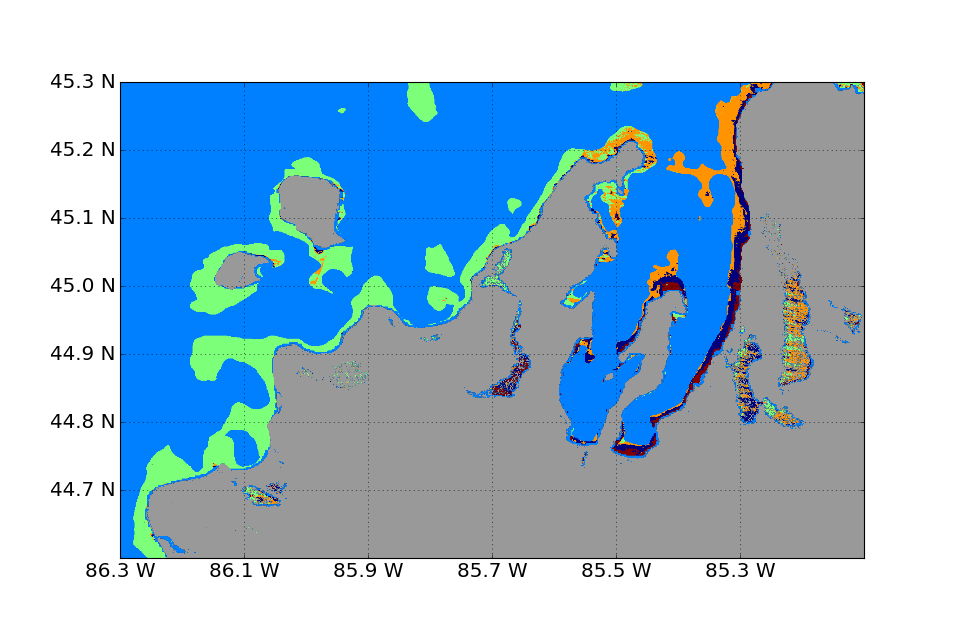

In [24]:
data_path = '/nfs0/data_ocolor/michigan/michigan1617/fused_data/20160726_208_mumml2_s2l2.nc'
data = Nansat(data_path)
class_number = 5

bottoms = np.arange(30, 0)
c = bottom_classification(data, class_number, h_max=20)
c[c == 0 ] = np.nan
show_it(c,land_mask=mask, coord_grid='on', size=(12,8))

<IPython.core.display.Javascript object>


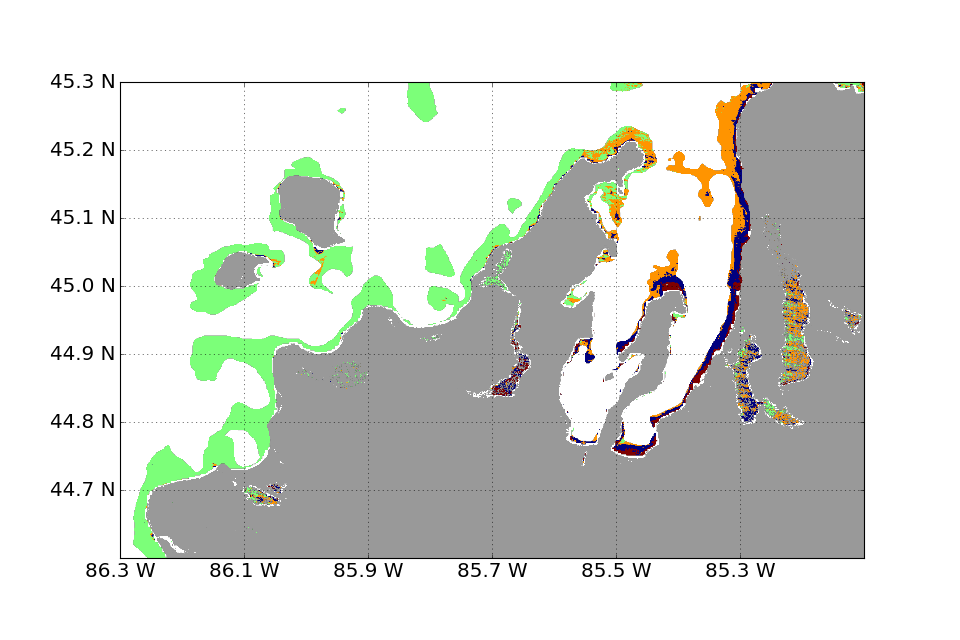

In [29]:
c = np.where(c == 1, np.nan, c)
show_it(c,land_mask=mask, coord_grid='on', size=(12,8))

=>michigan.grd<=


/data0/home/artemm/miniconda/envs/niersc/lib/python2.7/site-packages/ipykernel/__main__.py:18: RuntimeWarning: invalid value encountered in greater


Rrs_412
Rrs_443
Rrs_488
Rrs_531
Rrs_645
Rrs_678


<IPython.core.display.Javascript object>


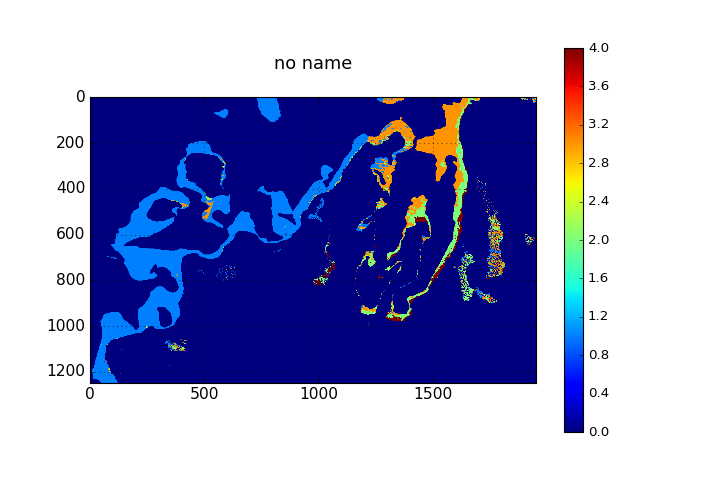

In [9]:
class_number = 5

bottoms = np.arange(30, 0)
c = bottom_classification(data, class_number)
show_it(c)

In [13]:
for a in range(0, len(bottoms) - 1):
    print('from %s m to %s m' % (bottoms[i], bottoms[i + 1]))
    c.apprend(bottom_classification(data, class_number, h_max=bottoms[i], h_min=bottoms[i + 1]))

In [16]:
data

----------------------------------------
/nfs0/data_ocolor/michigan/michigan1617/fused_data/20160705_187_mumml2_s2l2.nc
----------------------------------------
Mapper: generic
----------------------------------------
Band : 1 Rrs_412
  _FillValue: 9.969209968386869e+36
  grid_mapping: crs
  name: Rrs_412
  dataType: 7
  long_name: GDAL Band Number 1
  SourceFilename: NETCDF:"/nfs0/data_ocolor/michigan/michigan1617/fused_data/20160705_187_mumml2_s2l2.nc":Rrs_4121
  SourceBand: 1
  wkv: 
Band : 2 Rrs_443
  _FillValue: 9.969209968386869e+36
  name: Rrs_443
  dataType: 7
  long_name: GDAL Band Number 2
  SourceFilename: NETCDF:"/nfs0/data_ocolor/michigan/michigan1617/fused_data/20160705_187_mumml2_s2l2.nc":Rrs_4432
  SourceBand: 1
  wkv: 
Band : 3 Rrs_488
  _FillValue: 9.969209968386869e+36
  name: Rrs_488
  dataType: 7
  long_name: GDAL Band Number 3
  SourceFilename: NETCDF:"/nfs0/data_ocolor/michigan/michigan1617/fused_data/20160705_187_mumml2_s2l2.nc":Rrs_4883
  SourceBand: 1
  wkv: 


In [30]:
wavelengths = Data.wavelengths['modis']['1x1km_bands']
data_info = pd.DataFrame({'wavelengths': wavelengths})
for cl in range(class_number):
    print('class: %s' % cl)
    class_arr = []
    for band in wavelengths:
        arr = data['Rrs_%s' % band]
        # all 999 pixels will combined in one class
        arr[c == cl] = np.nan
        class_arr.append(arr.ravel())
    
    class_arr = np.array(class_arr).T
    data_info['Rrs, class: %s' % cl] = pd.Series(np.nanmean(class_arr, axis=0), index=data_info.index)


class: 0
class: 1
class: 2
class: 3
class: 4


In [31]:
data_info

,wavelengths,"Rrs, class: 0","Rrs, class: 1","Rrs, class: 2","Rrs, class: 3","Rrs, class: 4"
0,412,0.004325,0.004280,0.004238,0.004315,0.004310
1,443,0.005105,0.005073,0.005062,0.005103,0.005091
2,488,0.005456,0.005448,0.005398,0.005455,0.005455
3,531,0.004543,0.004557,0.004487,0.004555,0.004549
4,645,0.000898,0.000873,0.000871,0.000895,0.000888
5,678,0.000748,0.000719,0.000713,0.000742,0.000737


<IPython.core.display.Javascript object>


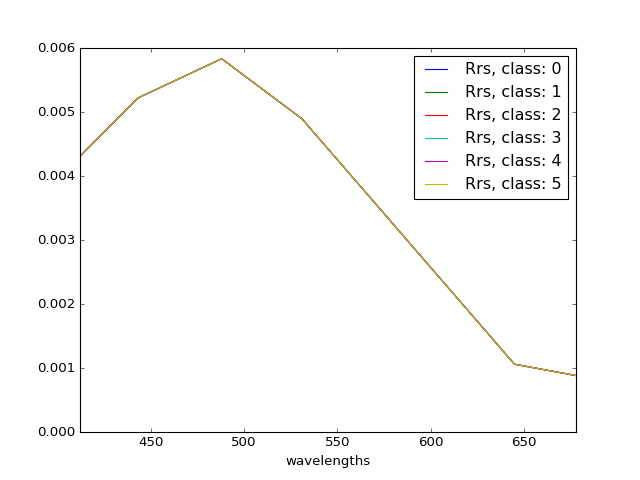

In [11]:
data_info.plot(x='wavelengths')

In [81]:
np.arange(30, 0, -1)

array([30, 29, 28, 27, 26, 25, 24, 23, 22, 21, 20, 19, 18, 17, 16, 15, 14,
       13, 12, 11, 10,  9,  8,  7,  6,  5,  4,  3,  2,  1])